<a href="https://colab.research.google.com/github/Nago625/nlp_2025/blob/main/problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 61.4 MB/s eta 0:00:00


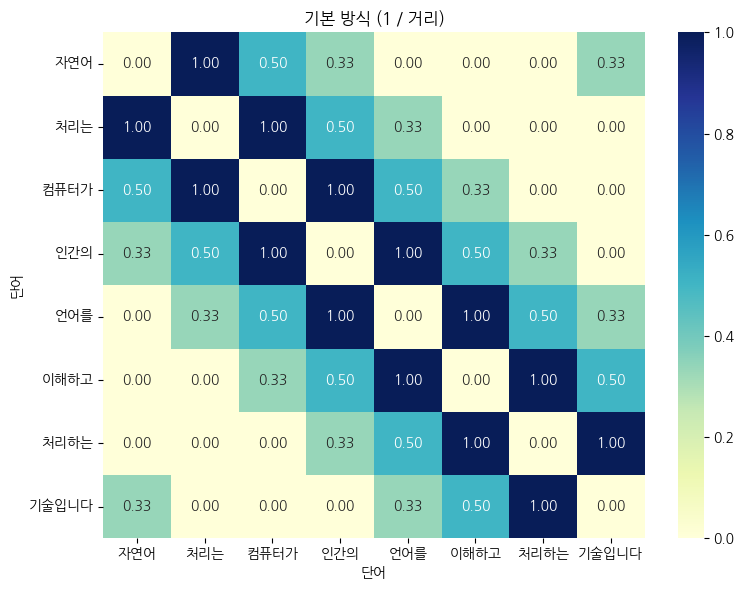


 기본 방식 통계:
  총 빈도: 82.33
  0이 아닌 원소 수: 126
  최대값: 1.00
  최소값: 0.33
  평균값: 0.65


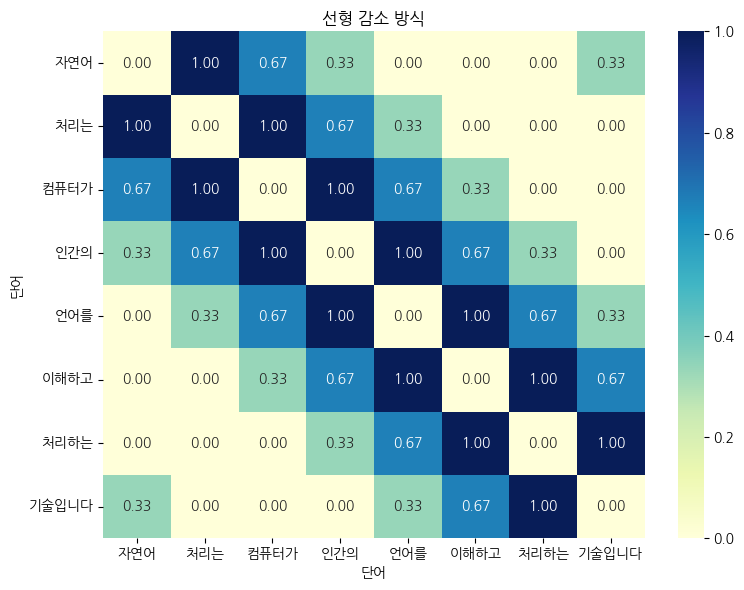


 선형 감소 통계:
  총 빈도: 89.33
  0이 아닌 원소 수: 126
  최대값: 1.00
  최소값: 0.33
  평균값: 0.71


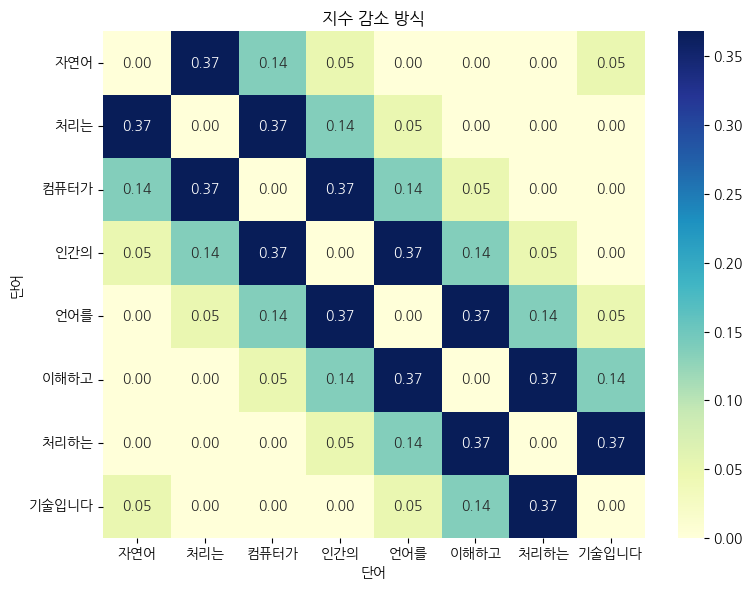


 지수 감소 통계:
  총 빈도: 25.77
  0이 아닌 원소 수: 126
  최대값: 0.37
  최소값: 0.05
  평균값: 0.20


In [3]:
# 필수 라이브러리 불러오기
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import scipy.sparse as sparse

!pip install koreanize_matplotlib
import koreanize_matplotlib

# 1. 샘플 말뭉치 생성
corpus = """
자연어 처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다.
컴퓨터는 자연어 처리를 통해 텍스트를 분석하고 의미를 추출합니다.
인공지능과 기계학습은 자연어 처리의 핵심 기술입니다.
딥러닝 모델은 자연어 처리 성능을 크게 향상시켰습니다.
"""

# 2. 전처리 및 토큰화
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    sentences = re.split(r'[.!?]\s*', text.strip())
    tokenized_sentences = []
    for sentence in sentences:
        tokens = re.sub(r'[^\w\s가-힣]', '', sentence).split()
        tokenized_sentences.append(tokens)
    return tokenized_sentences

tokenized_corpus = preprocess_text(corpus)

# 3. 어휘 사전 생성
def build_vocabulary(tokenized_sentences):
    words = [word for sent in tokenized_sentences for word in sent]
    word_counts = Counter(words)
    word_to_id = {word: i for i, (word, _) in enumerate(word_counts.items())}
    id_to_word = {i: word for word, i in word_to_id.items()}
    return word_to_id, id_to_word, word_counts

word_to_id, id_to_word, word_counts = build_vocabulary(tokenized_corpus)

# 4. 거리 기반 가중치 적용한 동시출현 행렬 생성 함수
def build_cooccurrence_matrix_custom_weight(tokenized_corpus, word_to_id, window_size=2, mode='default'):
    vocab_size = len(word_to_id)
    co_dict = defaultdict(float)

    for sentence in tokenized_corpus:
        for i, center_word in enumerate(sentence):
            if center_word not in word_to_id:
                continue
            center_id = word_to_id[center_word]

            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i == j:
                    continue
                context_word = sentence[j]
                if context_word not in word_to_id:
                    continue
                context_id = word_to_id[context_word]
                distance = abs(i - j)

                # 거리 기반 가중치 방식
                if mode == 'linear':
                    weight = (window_size + 1 - distance) / window_size  # 선형 감소
                elif mode == 'exp':
                    weight = np.exp(-distance)  # 지수 감소
                else:
                    weight = 1.0 / distance  # 기본

                co_dict[(center_id, context_id)] += weight

    rows, cols, data = zip(*[(i, j, v) for (i, j), v in co_dict.items()])
    matrix = sparse.csr_matrix((data, (rows, cols)), shape=(vocab_size, vocab_size))
    return matrix

# 5. 히트맵 시각화 함수
def visualize_heatmap(matrix, id_to_word, top_n=8, title=''):
    top_ids = list(range(min(top_n, len(id_to_word))))
    sub_matrix = matrix[top_ids, :][:, top_ids].toarray()
    labels = [id_to_word[i] for i in top_ids]

    plt.figure(figsize=(8, 6))
    sns.heatmap(sub_matrix, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap='YlGnBu')
    plt.title(title)
    plt.xlabel("단어")
    plt.ylabel("단어")
    plt.tight_layout()
    plt.show()

# 6. 행렬 통계 분석 함수
def analyze_matrix(matrix, label=''):
    dense = matrix.toarray()
    nonzero = dense[dense > 0]
    print(f"\n {label} 통계:")
    print(f"  총 빈도: {matrix.sum():.2f}")
    print(f"  0이 아닌 원소 수: {matrix.nnz}")
    print(f"  최대값: {nonzero.max():.2f}")
    print(f"  최소값: {nonzero.min():.2f}")
    print(f"  평균값: {nonzero.mean():.2f}")

# 7. 각 가중치 방식 실행 및 결과 비교
window_size = 3

# 기본 방식 (1 / distance)
matrix_default = build_cooccurrence_matrix_custom_weight(tokenized_corpus, word_to_id, window_size, mode='default')
visualize_heatmap(matrix_default, id_to_word, title='기본 방식 (1 / 거리)')
analyze_matrix(matrix_default, '기본 방식')

# 선형 감소 방식
matrix_linear = build_cooccurrence_matrix_custom_weight(tokenized_corpus, word_to_id, window_size, mode='linear')
visualize_heatmap(matrix_linear, id_to_word, title='선형 감소 방식')
analyze_matrix(matrix_linear, '선형 감소')

# 지수 감소 방식
matrix_exp = build_cooccurrence_matrix_custom_weight(tokenized_corpus, word_to_id, window_size, mode='exp')
visualize_heatmap(matrix_exp, id_to_word, title='지수 감소 방식')
analyze_matrix(matrix_exp, '지수 감소')
